In [2]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#tf.debugging.set_log_device_placement(True)

In [3]:
try:
    #path = get_file('kddcup.data.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz')
    #path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
    path = './nslkdd/KDDTrain+.txt'
except:
    print('Error downloading')
    raise
    
df = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(df)))
#df = df.sample(frac=0.01, replace=False) # Uncomment this line to sample only 1% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)


df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome',
    'difficulty_rating'
]

Read 125973 rows.


In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [5]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

df_trainer = None

print(df['outcome'].nunique())
print(df.groupby('outcome')['outcome'].count())


23
outcome
back                 956
buffer_overflow       30
ftp_write              8
guess_passwd          53
imap                  11
ipsweep             3599
land                  18
loadmodule             9
multihop               7
neptune            41214
nmap                1493
normal             67343
perl                   3
phf                    4
pod                  201
portsweep           2931
rootkit               10
satan               3633
smurf               2646
spy                    2
teardrop             892
warezclient          890
warezmaster           20
Name: outcome, dtype: int64


In [59]:
def set_bin_class(df):
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 1
        else:
            df.at[i, 'outcome'] = 0
            
set_bin_class(df)

num_classes = 0
while num_classes != 2: ###I need a sample that contains all the types of attacks, otherwise I cannot classify some of them

    df_trainer = df.sample(frac=1.0, replace=False) # Uncomment this line to sample only 10% of the dataset
    
    # Convert to numpy - Classification
    x_columns = df_trainer.columns.drop(['outcome','difficulty_rating'])
    x = df_trainer[x_columns].values
    dummies = pd.get_dummies(df_trainer['outcome']) # Classification
    #dummies = pd.get_dummies(df['outcome']) # Classification

    outcomes = dummies.columns
    num_classes = len(outcomes)
    y = dummies.values


In [60]:
print(df_trainer.groupby('outcome')['outcome'].count())
print(df_trainer.head())

outcome
0    67343
1    58630
Name: outcome, dtype: int64
       duration  src_bytes  dst_bytes  wrong_fragment    urgent        hot  \
23392 -0.110249  -0.007731  -0.004919       -0.089486 -0.007736  -0.095075   
21256 -0.110249  -0.006752  -0.004919       -0.089486 -0.007736  -0.095075   
61960 -0.110249  -0.007762  -0.004919       -0.089486 -0.007736  -0.095075   
52034 -0.099498  -0.007500  -0.003886       -0.089486 -0.007736  13.858618   
92100 -0.110249  -0.007755  -0.004900       -0.089486 -0.007736  -0.095075   

       num_failed_logins  num_compromised  root_shell  su_attempted  ...  \
23392          -0.027023        -0.011664   -0.036652     -0.024436  ...   
21256          -0.027023        -0.011664   -0.036652     -0.024436  ...   
61960          -0.027023        -0.011664   -0.036652     -0.024436  ...   
52034          -0.027023        -0.011664   -0.036652     -0.024436  ...   
92100          -0.027023        -0.011664   -0.036652     -0.024436  ...   

       flag-SF  

In [61]:
def baseline_model():
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=50, verbose=0)

In [62]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [70]:
#from sklearn.neural_network import MLPClassifier
#mlp = MLPClassifier(hidden_layer_sizes=(64,64,),max_iter=50,verbose=True)
#mlp.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

y_test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.0s finished


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

In [71]:
results = []
for val in y_test:
    results.append(val[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16741
           1       1.00      1.00      1.00     14753

   micro avg       1.00      1.00      1.00     31494
   macro avg       1.00      1.00      1.00     31494
weighted avg       1.00      1.00      1.00     31494
 samples avg       1.00      1.00      1.00     31494

16741 0


/usr/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


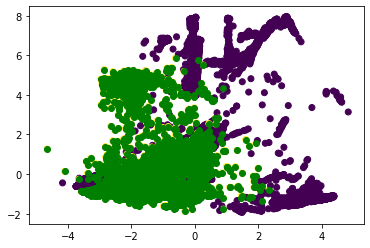

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
#predictions = mlp.predict(x_test)
#print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_test)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

#this block prepares a true_normal_df for visualization, so we can compare against the two groups generated by K-Means Clustering
true_normal_df = principalDf.copy() #get the PCA1 and PCA2 columns from the principalDf (original df), copy them into a new true_normal_df
true_normal_df['outcome'] = results #copy the outcome column from the original dataframe to the true_normal_df
true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 1].index) #delete all rows from the true_normal_df that have an outcome that is NOT normal
print(len(true_normal_df['outcome']), (true_normal_df.outcome == 'normal').sum()) #proof that every outcome in our table is normal
true_normal_df.drop(['outcome'], axis = 1) #finally, drop the outcome column from the true_normal_df, and we are left with PCA1 and PCA2 cols that correspond to the true normal rows, so we can plot and visualize these in the next step

import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = results, cmap = 'viridis')
plt.scatter(true_normal_df['principal component 1'], true_normal_df['principal component 2'], color = 'g', alpha = 1)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=50)

Train on 94479 samples, validate on 31494 samples
Epoch 1/50
94479/94479 - 2s - loss: 0.0954 - accuracy: 0.9679 - val_loss: 0.0797 - val_accuracy: 0.9733
Epoch 2/50
94479/94479 - 2s - loss: 0.0797 - accuracy: 0.9725 - val_loss: 0.0774 - val_accuracy: 0.9727
Epoch 3/50
94479/94479 - 2s - loss: 0.0773 - accuracy: 0.9726 - val_loss: 0.0760 - val_accuracy: 0.9732
Epoch 4/50
94479/94479 - 2s - loss: 0.0759 - accuracy: 0.9728 - val_loss: 0.0770 - val_accuracy: 0.9721
Epoch 5/50
94479/94479 - 2s - loss: 0.0754 - accuracy: 0.9733 - val_loss: 0.0739 - val_accuracy: 0.9730
Epoch 6/50
94479/94479 - 2s - loss: 0.0746 - accuracy: 0.9730 - val_loss: 0.0740 - val_accuracy: 0.9729
Epoch 7/50
94479/94479 - 2s - loss: 0.0744 - accuracy: 0.9732 - val_loss: 0.0764 - val_accuracy: 0.9716
Epoch 8/50
94479/94479 - 2s - loss: 0.0751 - accuracy: 0.9732 - val_loss: 0.0726 - val_accuracy: 0.9733
Epoch 9/50
94479/94479 - 2s - loss: 0.0736 - accuracy: 0.9733 - val_loss: 0.0740 - val_accuracy: 0.9720
Epoch 10/50
94

In [74]:
import numpy as np
from sklearn import metrics

pred = estimator.predict(x_test)

In [75]:
y_eval = np.argmax(y_test, axis=1)
print(y_eval)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

[1 0 0 ... 1 0 0]
Validation score: 0.9743125674731695


In [76]:
# Convert to numpy - Classification
x_columns = df.columns.drop(['outcome','difficulty_rating'])
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

print(num_classes)

2


In [77]:
y_eval_full = np.argmax(y, axis=1)
full_pred = estimator.predict(x)
score = metrics.accuracy_score(y_eval_full, full_pred)
print("Validation score for entire dataset: {}".format(score))


Validation score for entire dataset: 0.9747406190215364
